# Global metrics during GRACE era

In this notebook, our own model prediction performance is evaluated. This includes comparisons with GRACE, WaterGAP, and other reconstructions.

In [43]:
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd  # noqa
import seaborn as sns
import xarray as xr
from dask.diagnostics import ProgressBar
from matplotlib_inline.backend_inline import set_matplotlib_formats
from statsmodels.tsa.seasonal import STL

import deepwaters  # noqa
from deepwaters import metrics
from deepwaters.regions import basins
from deepwaters.training import load_config
from deepwaters.utils import ROOT_DIR
from deepwaters.visualization import plot_basinwise_map

In [44]:
# Register dask progress bar
ProgressBar(minimum=5).register()

Max figure width:

| Font size | DIV | Text width |
|-----------|-----|------------|
| 11 pt     | 10  | 5.78 in    |
| 11 pt     | 11  | 6.01 in    |
| 11 pt     | 12  | 6.20 in    |
| 11 pt     | 13  | 6.36 in    |

In [ ]:
set_matplotlib_formats("retina")
plt.style.use(ROOT_DIR / "config/style_paper.mplstyle")
FIGURE_DIR = ROOT_DIR / "docs/figures/si"

Open model predictions:

In [46]:
# Load and combine all test and train predictions
pred_dir = ROOT_DIR / "models/predictions/global"

pred_zarrs = [
    pred_dir / "ensemble_alltrain_10folds_combined.zarr",
]
preds = xr.merge([xr.open_zarr(store) for store in pred_zarrs])

Load config to read target variable:

In [47]:
# Load data configuration
config_file = ROOT_DIR / "config/continental/train_lstm_gap.yaml"
data_config = load_config(config_file)["data"]
target_var = data_config["target_var"]
print(f"{target_var = }")

target_var = 'twsa_csr'


Get target, WaterGAP and land mask:

In [48]:
targets_store = ROOT_DIR / "data/processed/targets.zarr"
inputs_store = ROOT_DIR / "data/processed/inputs.zarr"
recs_store = ROOT_DIR / "data/processed/reconstructions.zarr"

tgts = xr.open_zarr(targets_store)
inps = xr.open_zarr(inputs_store)
recs = xr.open_zarr(recs_store)

In [49]:
mask = (tgts.land_mask_jpl * tgts.land_mask_gsfc * inps.grl_ata_mask).compute()
gap = inps.twsa_gap
true = tgts[target_var]

Merge everything:

In [50]:
mgd = xr.merge([true, gap, preds, recs])
# Apply mask
mgd = mgd.where(mask == 1)
mgd

<xarray.Dataset> Size: 29GB
Dimensions:                                    (time: 1480, lat: 360, lon: 720)
Coordinates:
  * lat                                        (lat) float64 3kB -89.75 ... 8...
  * lon                                        (lon) float64 6kB -179.8 ... 1...
  * time                                       (time) datetime64[ns] 12kB 190...
Data variables: (12/19)
    twsa_csr                                   (time, lat, lon) float32 2GB dask.array<chunksize=(1480, 360, 180), meta=np.ndarray>
    twsa_gap                                   (time, lat, lon) float32 2GB dask.array<chunksize=(1480, 120, 120), meta=np.ndarray>
    pred_ensemble_alltrain_gap_lnll_latest     (time, lat, lon) float32 2GB dask.array<chunksize=(1480, 120, 120), meta=np.ndarray>
    pred_ensemble_alltrain_nogap_lnll_latest   (time, lat, lon) float32 2GB dask.array<chunksize=(1480, 120, 120), meta=np.ndarray>
    sigma_ensemble_alltrain_gap_lnll_latest    (time, lat, lon) float32 2GB dask.array<chunksize=(1480, 120, 120), meta=np.ndarray>
    sigma_ensemble_alltrain_nogap_lnll_latest  (time, lat, lon) float32 2GB dask.array<chunksize=(1480, 120, 120), meta=np.ndarray>
    ...                                         ...
    yin_csr_full                               (time, lat, lon) float32 2GB dask.array<chunksize=(1480, 120, 120), meta=np.ndarray>
    yin_csr_zerofill                           (time, lat, lon) float32 2GB dask.array<chunksize=(1480, 120, 120), meta=np.ndarray>
    yin_gsfc_full                              (time, lat, lon) float32 2GB dask.array<chunksize=(1480, 120, 120), meta=np.ndarray>
    yin_gsfc_zerofill                          (time, lat, lon) float32 2GB dask.array<chunksize=(1480, 120, 120), meta=np.ndarray>
    yin_jpl_full                               (time, lat, lon) float32 2GB dask.array<chunksize=(1480, 120, 120), meta=np.ndarray>
    yin_jpl_zerofill                           (time, lat, lon) float32 2GB dask.array<chunksize=(1480, 120, 120), meta=np.ndarray>
Attributes:
    long_name:      Terrestrial Water Storage Anomaly
    standard_name:  twsa
    units:          mm

Define more readable variable names:

In [51]:
vars_verbose = {
    "twsa_csr": "CSR-M (ground truth)",
    "pred_ensemble_alltrain_gap_lnll_latest": "Ours, w/ WGHM",
    "pred_ensemble_alltrain_nogap_lnll_latest": "Ours, w/o WGHM",
    "twsa_gap": "WaterGAP (WGHM)",
    "humphrey_gsfc_detrend": "Humphrey's GSFC REC",
    "li_csr_full": "Li's CSR REC",
    "yin_csr_full": "Yin's CSR REC",
}

In [52]:
eval_vars = list(vars_verbose.keys())
eval_vars.remove(target_var)

## Time series of reconstruction

### Global

In [53]:
# Calculate the required plot rows and columns
NCOLS = 2
nrows = int(np.ceil(len(eval_vars) / NCOLS))

subplot_kwargs = dict(
    nrows=nrows, ncols=NCOLS, sharex=True, sharey=True, figsize=(6, 5)
)
title_kwargs = dict(fontsize=16, weight="bold")

# Default Seaborn color palette, but without gray
cmap = [*sns.color_palette()]
cmap.pop(7);

In [54]:
df_mean = (
    mgd[[*eval_vars, target_var]]
    .sel(time=slice("1940", None))
    .dw.weight_lat()
    .mean(["lat", "lon"])
    .to_pandas()
)
# Split GRACE timeseries in before/after GRACE-FO gap
# Interpolate the missing time steps within each series
grace_full = df_mean[target_var]
df_mean[target_var] = grace_full[:"2018-01-01"].interpolate(limit_area="inside")
df_mean[f"{target_var}_fo"] = grace_full.loc["2018-01-01":].interpolate(
    limit_area="inside"
)

# Perform LOESS decomposition
TREND_YRS = 3
period = 12
# trend usually is 150 % of seasonal
trend = 12 * TREND_YRS
seasonal = round(trend / 1.5)

df_trend = df_mean.copy()
for var in df_trend:
    series = df_mean[var].dropna()
    res = STL(series, period=period, seasonal=seasonal + 1, trend=trend + 1).fit()
    # Remove extrapolated start and end parts
    df_trend[var] = res.trend[(trend // 2) :][: -(trend // 2)]

# Combine GRACE and GRACE-FO series
df_trend[target_var] = df_trend[target_var].combine_first(df_trend[f"{target_var}_fo"])

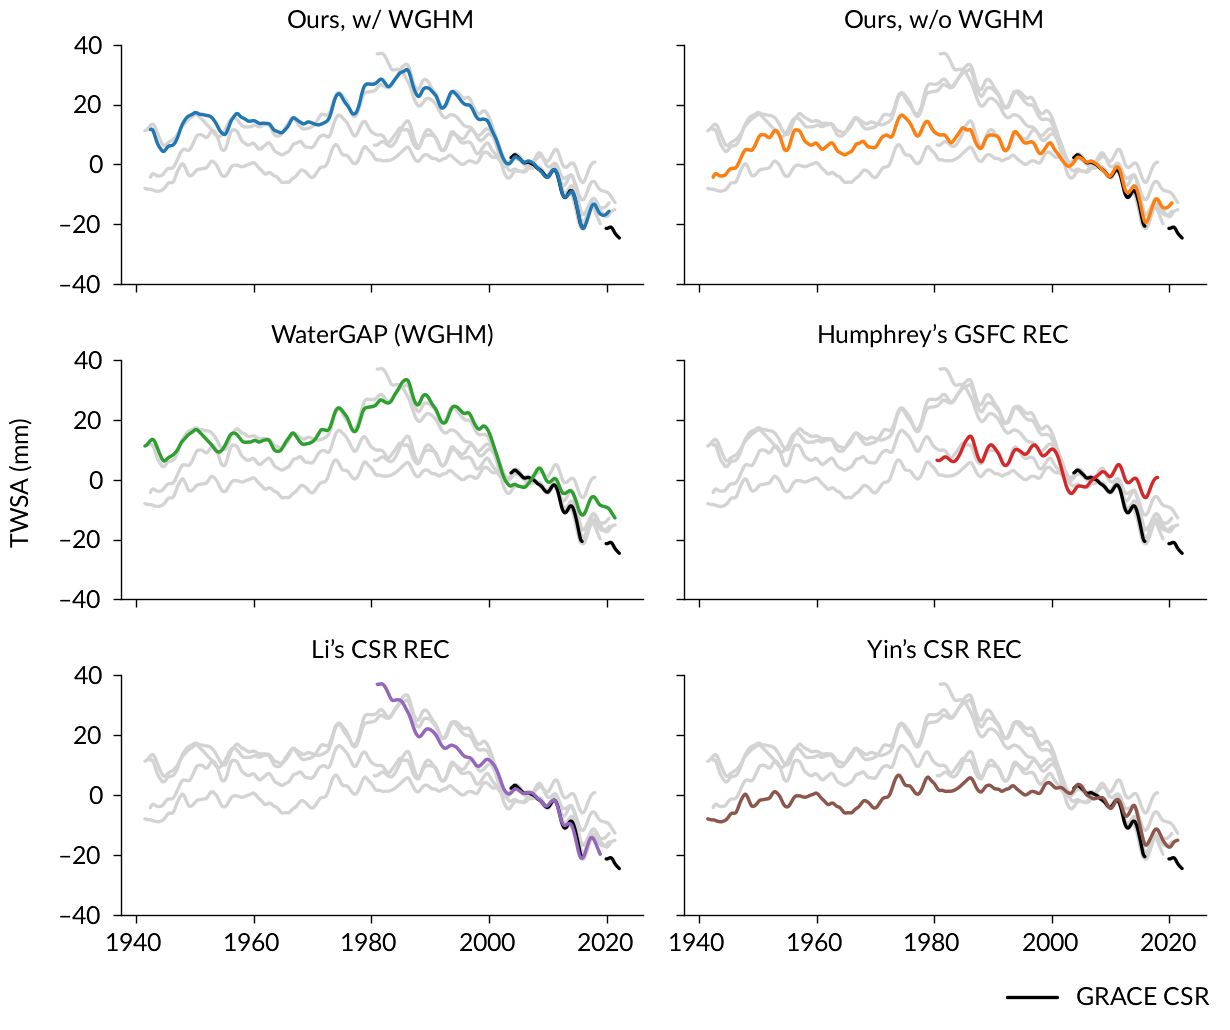

In [55]:
fig, axs = plt.subplots(**subplot_kwargs)

# Iterate over predictions/inputs
for i, (plot_var, ax) in enumerate(zip(eval_vars, axs.flat)):
    # Plot background
    for dvar in eval_vars:
        ax.plot(df_trend.index, df_trend[dvar], color="lightgray")
    # Plot target
    grace_label = "GRACE CSR" if i == 0 else None
    ax.plot(df_trend.index, df_trend[target_var], color="black", label=grace_label)
    # Plot prediction
    ax.plot(df_trend.index, df_trend[plot_var], color=cmap[i])
    ax.set(
        title=vars_verbose[plot_var],
        ylim=(-40, 40),
    )
    ax.xaxis.set_major_locator(mdates.YearLocator(base=20))
    ax.label_outer()

fig.legend(loc="lower right", bbox_to_anchor=(1, -0.05), title=None)
# Set common labels
fig.text(0, 0.5, "TWSA (mm)", ha="right", va="center", rotation="vertical")

fig.savefig(FIGURE_DIR / "trends_global.pdf", backend="pgf")

## Amazon basin

In [56]:
# Create data frame from averaged time series
BASIN = "Amazon"
df_mean = (
    mgd[[*eval_vars, target_var]]
    .sel(time=slice("1940", None))
    .dw.select_basins(BASIN, return_region=False)
    .dw.weight_lat()
    .mean(["lat", "lon"])
    .to_pandas()
)

# Split GRACE timeseries in before/after GRACE-FO gap
# Interpolate the missing time steps within each series
grace_full = df_mean[target_var]
df_mean[target_var] = grace_full[:"2018-01-01"].interpolate(limit_area="inside")
df_mean[f"{target_var}_fo"] = grace_full.loc["2018-01-01":].interpolate(
    limit_area="inside"
)

df_trend = df_mean.copy()
for var in df_trend:
    series = df_mean[var].dropna()
    res = STL(series, period=period, seasonal=seasonal + 1, trend=trend + 1).fit()
    # Remove extrapolated start and end parts
    df_trend[var] = res.trend[(trend // 2) :][: -(trend // 2)]

# Combine GRACE and GRACE-FO series
df_trend[target_var] = df_trend[target_var].combine_first(df_trend[f"{target_var}_fo"])

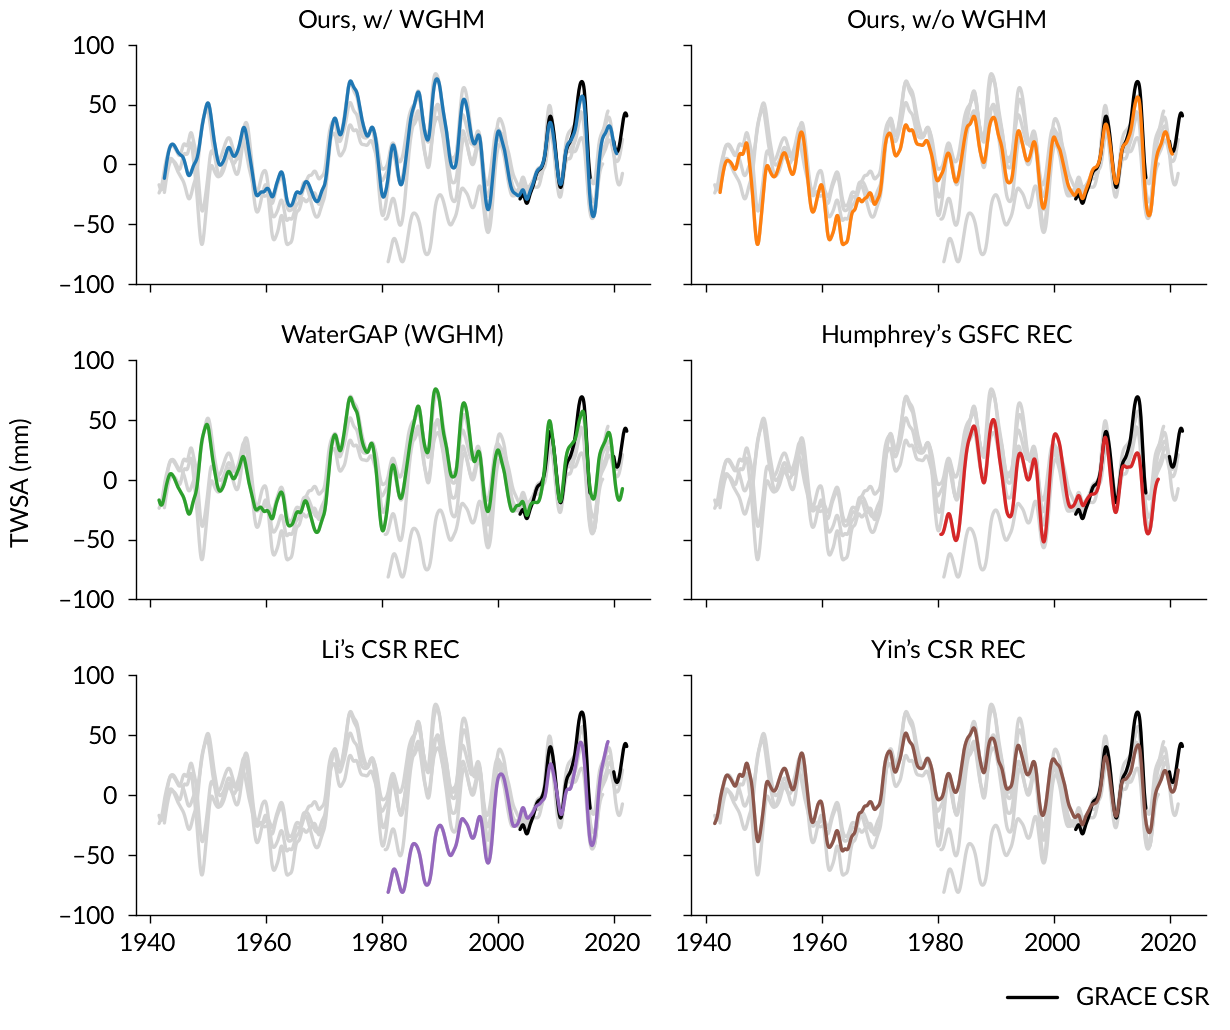

In [57]:
fig, axs = plt.subplots(**subplot_kwargs)

# Iterate over predictions/inputs
for i, (plot_var, ax) in enumerate(zip(eval_vars, axs.flat)):
    # Plot background
    for dvar in eval_vars:
        ax.plot(df_trend.index, df_trend[dvar], color="lightgray")
    # Plot target
    grace_label = "GRACE CSR" if i == 0 else None
    ax.plot(df_trend.index, df_trend[target_var], color="black", label=grace_label)
    # Plot prediction
    ax.plot(df_trend.index, df_trend[plot_var], color=cmap[i])
    ax.set(
        title=vars_verbose[plot_var],
        ylim=(-100, 100),
    )
    ax.xaxis.set_major_locator(mdates.YearLocator(base=20))

fig.legend(loc="lower right", bbox_to_anchor=(1.0, -0.05), title=None)
# Set common labels
fig.text(0, 0.5, "TWSA (mm)", ha="right", va="center", rotation="vertical")

fig.savefig(FIGURE_DIR / "trends_amazon.pdf", backend="pgf")

## Score / correlation world maps
### Pixel-wise RMSE

In [58]:
# Drop time steps where one of the variables is not available
mgd_nona = mgd[[*eval_vars, target_var]].where(mgd.dw.time_notnull(), drop=True)
preds_rmse = metrics.rmse(
    mgd_nona[target_var], mgd_nona[eval_vars], dim="time", skipna=True
)
np.seterr(divide="ignore", invalid="ignore")
da_rmse = preds_rmse.to_dataarray("model", name="rmse").compute()

[########################################] | 100% Completed | 22.79 s
[########################################] | 100% Completed | 22.85 s
[########################################] | 100% Completed | 9.44 s
[########################################] | 100% Completed | 9.53 s


In [59]:
plot_kwargs = dict(
    vmin=0,
    vmax=140,
    col_wrap=2,
    coastlines=True,
    gridlines=True,
    cmap="viridis",
    cbar_kwargs=dict(location="bottom", aspect=50, shrink=0.8, pad=0.03),
    rasterized=True,
    figsize=(6, 6.5),
)
basinlines_kwargs = dict(
    edgecolor="black",
    linewidth=0.5,
    facecolor="None",
    rasterized=True,
)
title_kwargs = dict(fontsize=16, weight="bold")

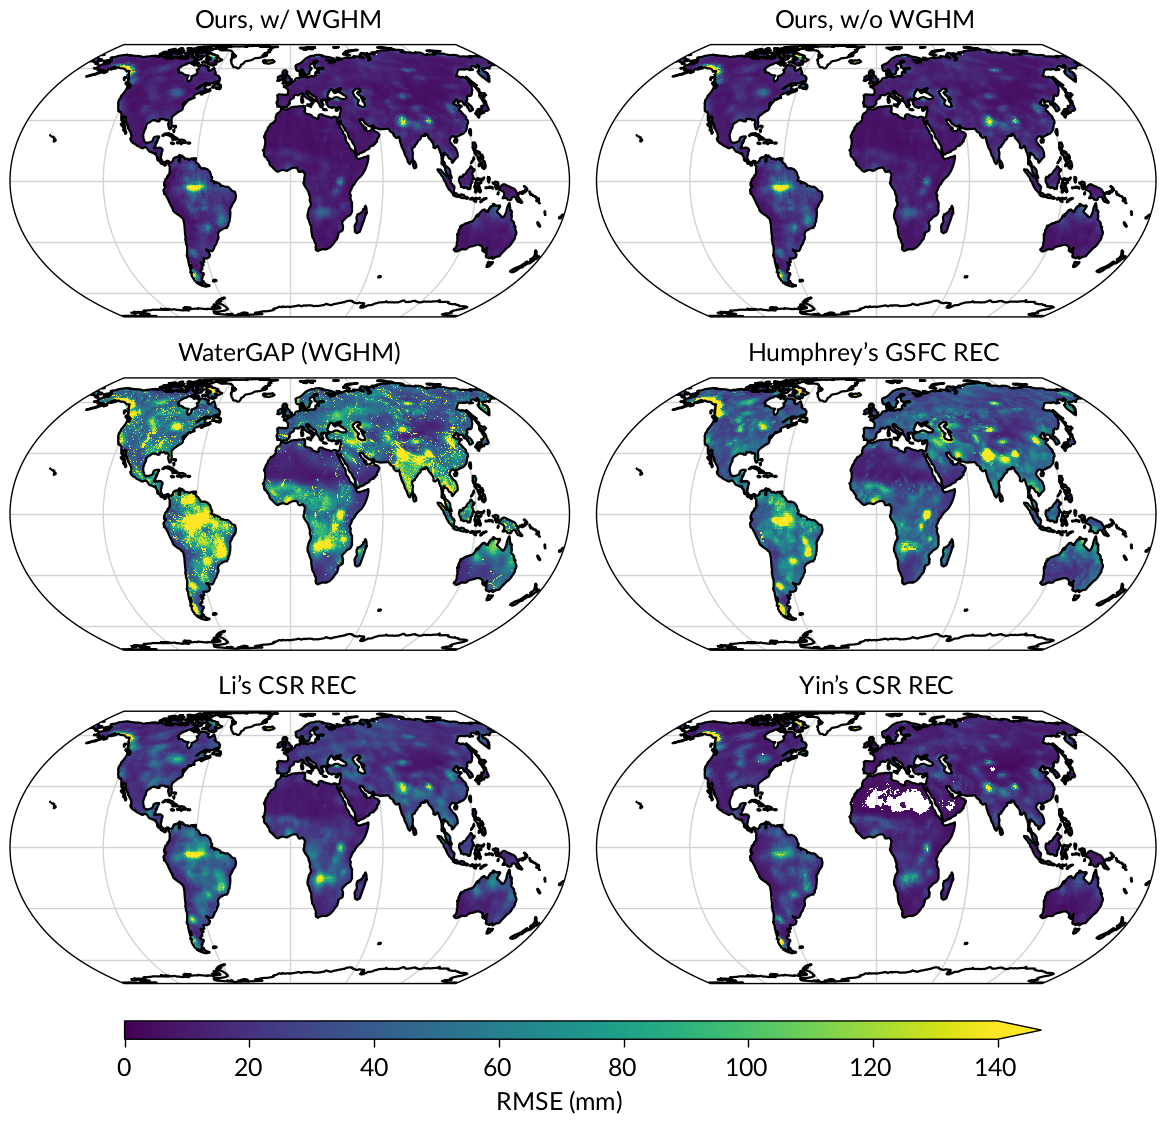

In [60]:
plot_kwargs["cbar_kwargs"]["label"] = "RMSE (mm)"
p = da_rmse.dw.projplot(col="model", **plot_kwargs)

for ax, model in zip(p.axs.flat, da_rmse.model.values):
    ax.set_title(vars_verbose[model])

p.fig.savefig(FIGURE_DIR / "metrics_rmse_gridwise.pdf", backend="pgf")

### Basin-wise RMSE

Calculate the basin average time series:

In [61]:
# Dims: ("model", "region")
basin_avg = (
    # Basins over 200,000 km²
    mgd_nona.dw.select_basins(top=72).dw.weight_lat().mean(["lat", "lon"])
).compute()

[########################################] | 100% Completed | 52.44 s
[########################################] | 100% Completed | 52.53 s


In [62]:
preds_basin_rmse = metrics.rmse(basin_avg[target_var], basin_avg[eval_vars], dim="time")
da_basin_rmse = preds_basin_rmse.to_dataarray("model", name="rmse").compute()

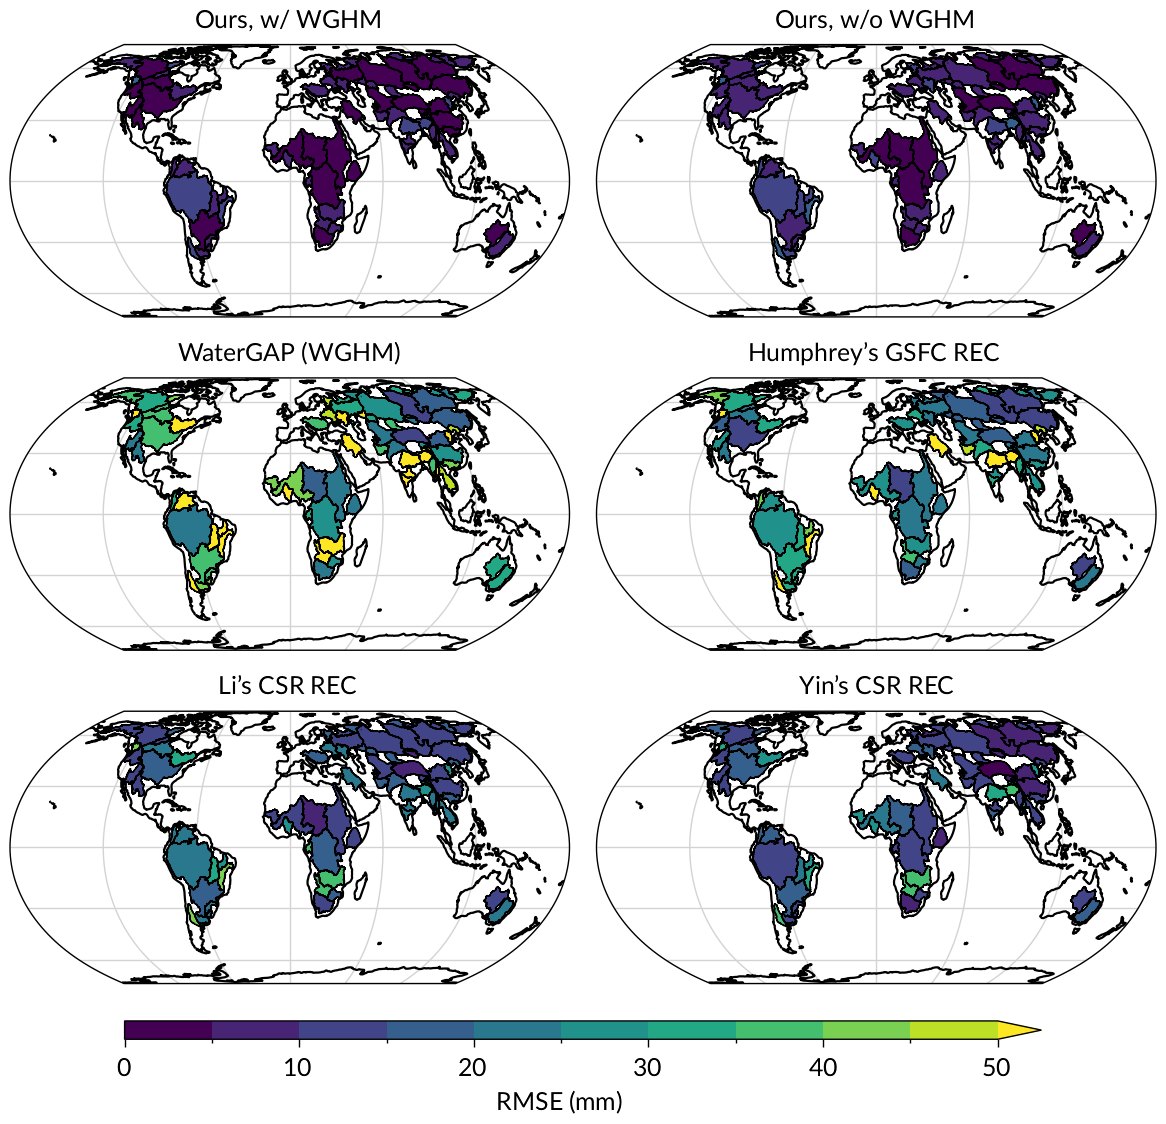

In [63]:
plot_kwargs["vmax"] = 50

p = plot_basinwise_map(da_basin_rmse, da_rmse, col="model", levels=11, **plot_kwargs)

# Plot basin shapes
basin_shapes = basins(top=72)
for ax, model in zip(p.axs.flat, da_rmse.model.values):
    ax.set_title(vars_verbose[model])
    basin_shapes.dw.projplot(ax=ax, **basinlines_kwargs)

p.fig.savefig(FIGURE_DIR / "metrics_rmse_basinwise.pdf", backend="pgf")

### Nash–Sutcliffe model efficiency coefficient (NSE)

Nash-Sutcliffe Efficiency (NSE) as per [Nash and Sutcliffe, 1970](https://doi.org/10.1016/0022-1694(70)90255-6).
$$
E_{\text{NSE}} = 1 - \frac{\sum_{i=1}^{N}[e_{i}-s_{i}]^2}
{\sum_{i=1}^{N}[e_{i}-\mu(e)]^2}
$$

where *N* is the length of the *simulations* and *evaluation*
periods, *e* is the *evaluation* series, *s* is (one of) the
*simulations* series, and *μ* is the arithmetic mean.

[########################################] | 100% Completed | 9.53 s
[########################################] | 100% Completed | 9.62 s


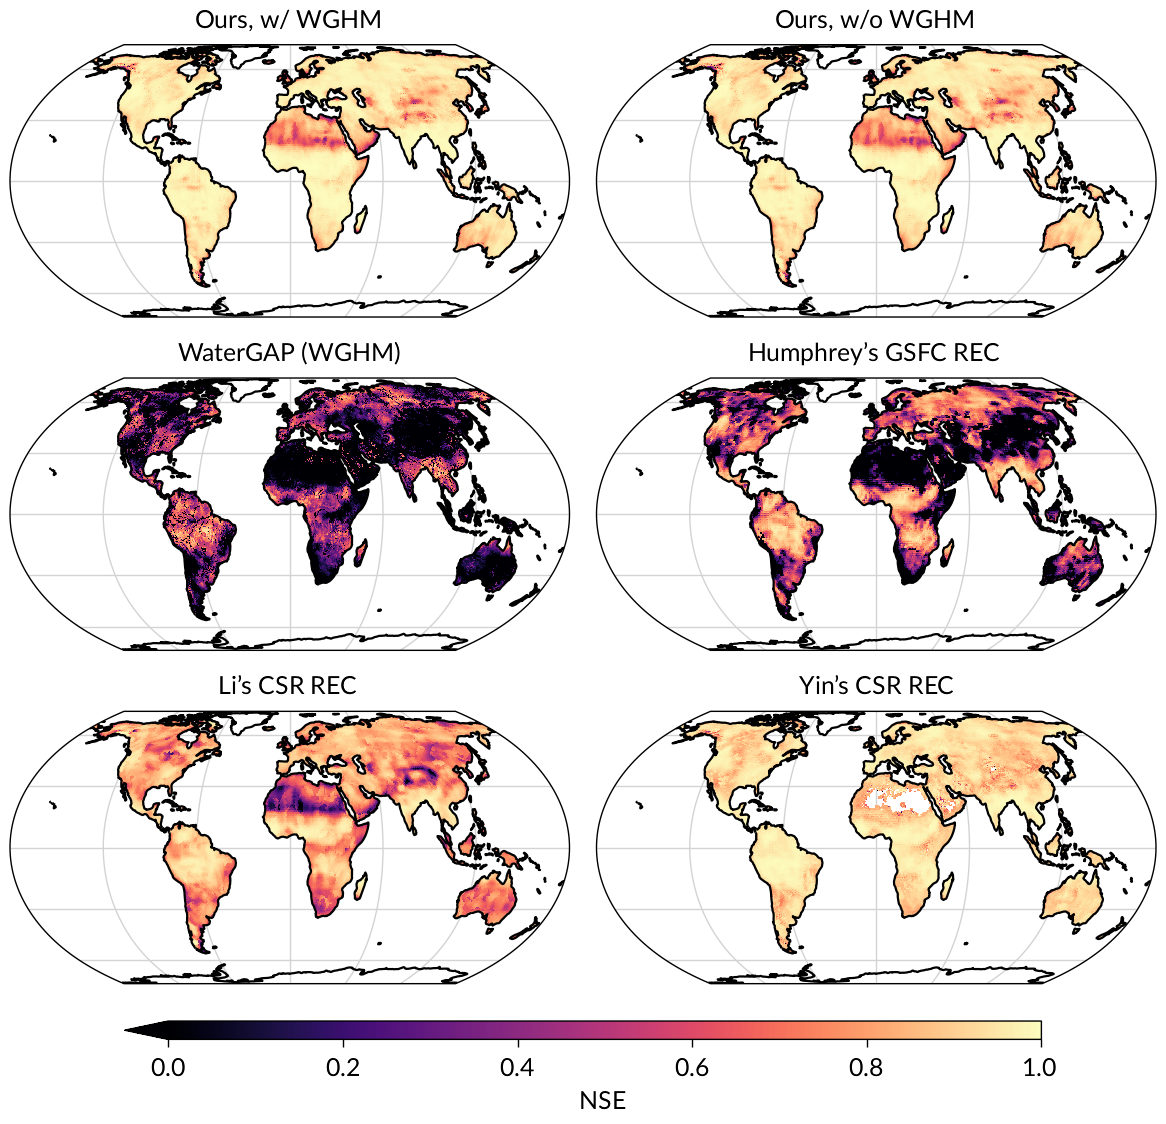

In [64]:
preds_nse = metrics.nse(
    mgd_nona[target_var], mgd_nona[eval_vars], dim="time", skipna=True
)
da_nse = preds_nse.to_dataarray("model", name="nse").compute()

plot_kwargs["vmin"] = 0
plot_kwargs["vmax"] = 1
plot_kwargs["cmap"] = "magma"
plot_kwargs["cbar_kwargs"]["label"] = "NSE"

p = da_nse.dw.projplot(col="model", **plot_kwargs)

for ax, model in zip(p.axs.flat, da_nse.model.values):
    ax.set_title(vars_verbose[model])
p.fig.savefig(FIGURE_DIR / "metrics_nse_gridwise.pdf", backend="pgf")

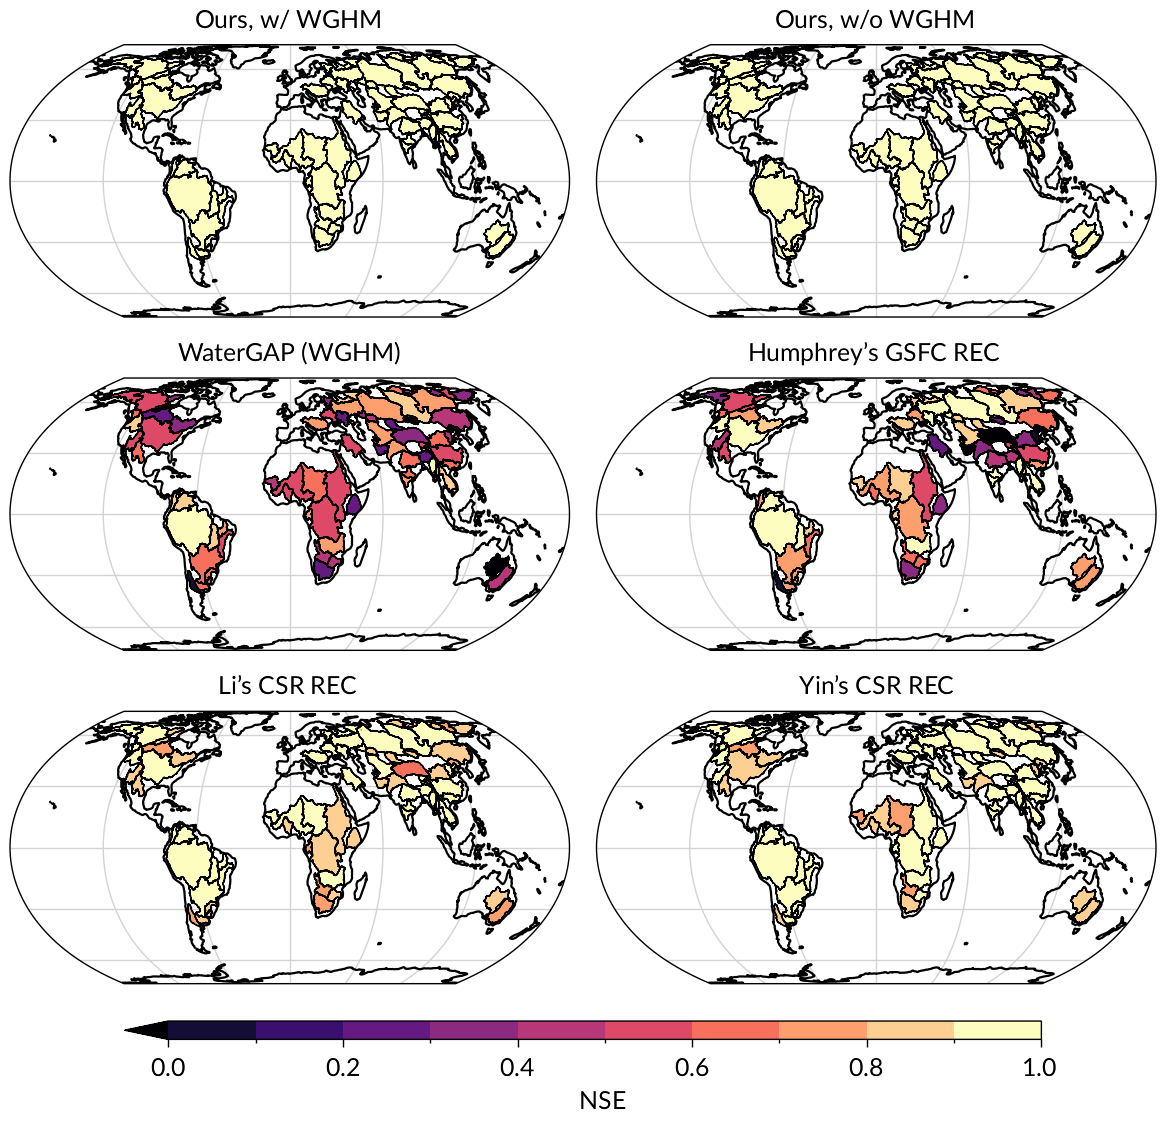

In [65]:
preds_basin_nse = metrics.nse(basin_avg[target_var], basin_avg[eval_vars], dim="time")
da_basin_nse = preds_basin_nse.to_dataarray("model", name="nse")

p = plot_basinwise_map(da_basin_nse, da_nse, col="model", levels=11, **plot_kwargs)

for ax, model in zip(p.axs.flat, da_nse.model.values):
    ax.set_title(vars_verbose[model])
    basin_shapes.dw.projplot(ax=ax, **basinlines_kwargs)
p.fig.savefig(FIGURE_DIR / "metrics_nse_basinwise.pdf", backend="pgf")

### Cyclostationary Nash–Sutcliffe model efficiency coefficient (NSE<sub>C</sub>)

Cyclostationary Nash-Sutcliffe Efficiency (NSE<sub>C</sub>) as per [Lehmann, 2022](https://doi.org/10.5194/hess-26-35-2022).
$$
E_{\text{NSE}_C} = 1 - \frac{\sum_{i=1}^{N}[e_{i}-s_{i}]^2}
{\sum_{i=1}^{N}[e_{i}-\mu_m(e)]^2}
$$

where *μ<sub>m</sub>* is the monthly mean.

[########################################] | 100% Completed | 9.45 s
[########################################] | 100% Completed | 9.54 s


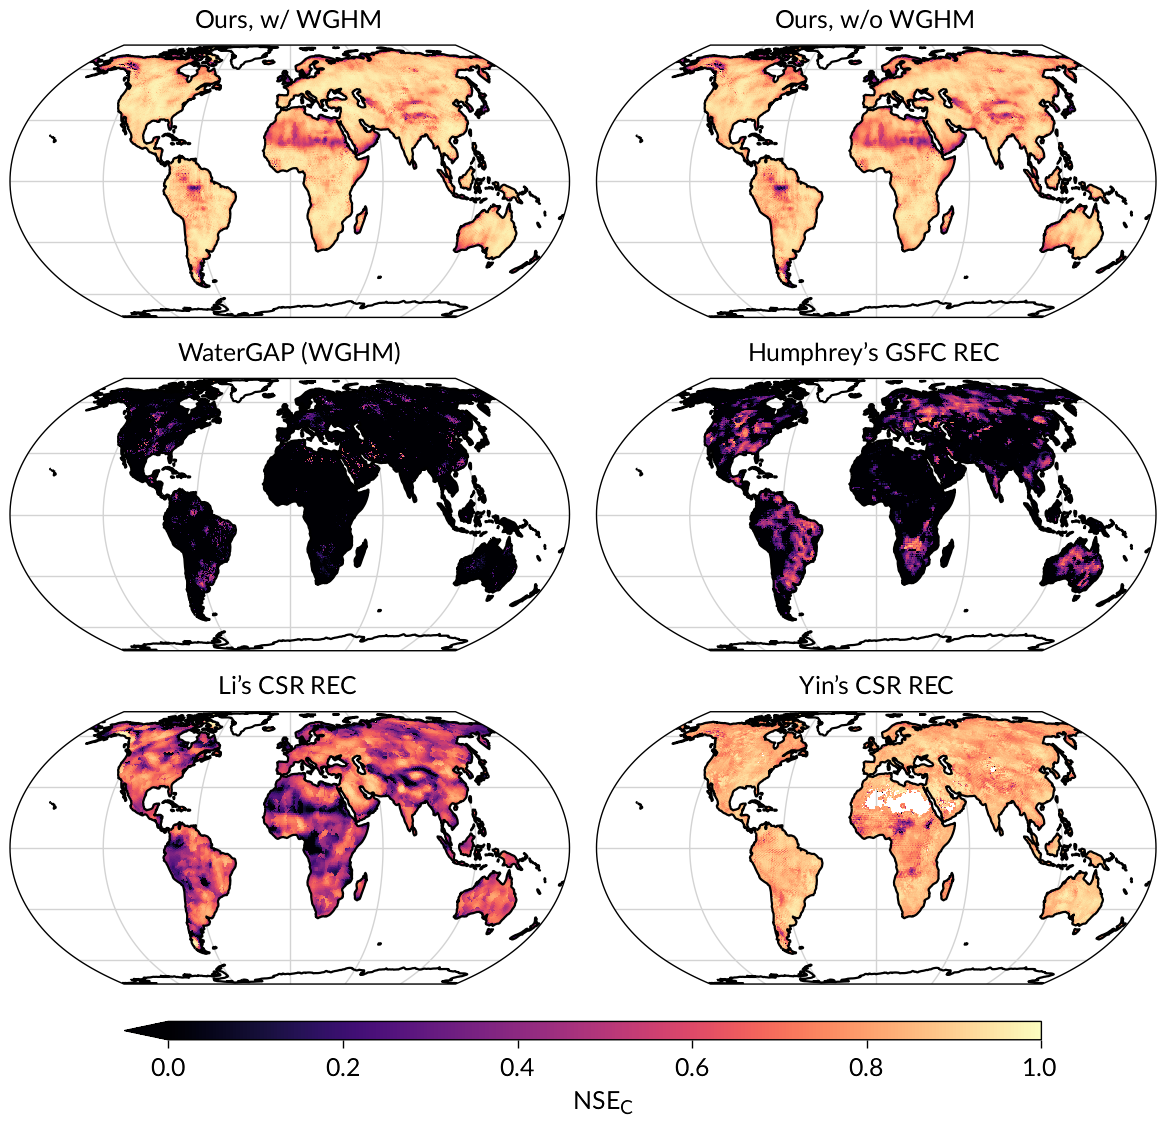

In [66]:
preds_nsec = metrics.nsec(mgd_nona[target_var], mgd_nona[eval_vars], skipna=True)
da_nsec = preds_nsec.to_dataarray("model", name="cnse").compute()

plot_kwargs["cbar_kwargs"]["label"] = r"NSE$_C$"


p = da_nsec.dw.projplot(col="model", **plot_kwargs)

for ax, model in zip(p.axs.flat, da_nsec.model.values):
    ax.set_title(vars_verbose[model])

p.fig.savefig(FIGURE_DIR / "metrics_nsec_gridwise.pdf", backend="pgf")

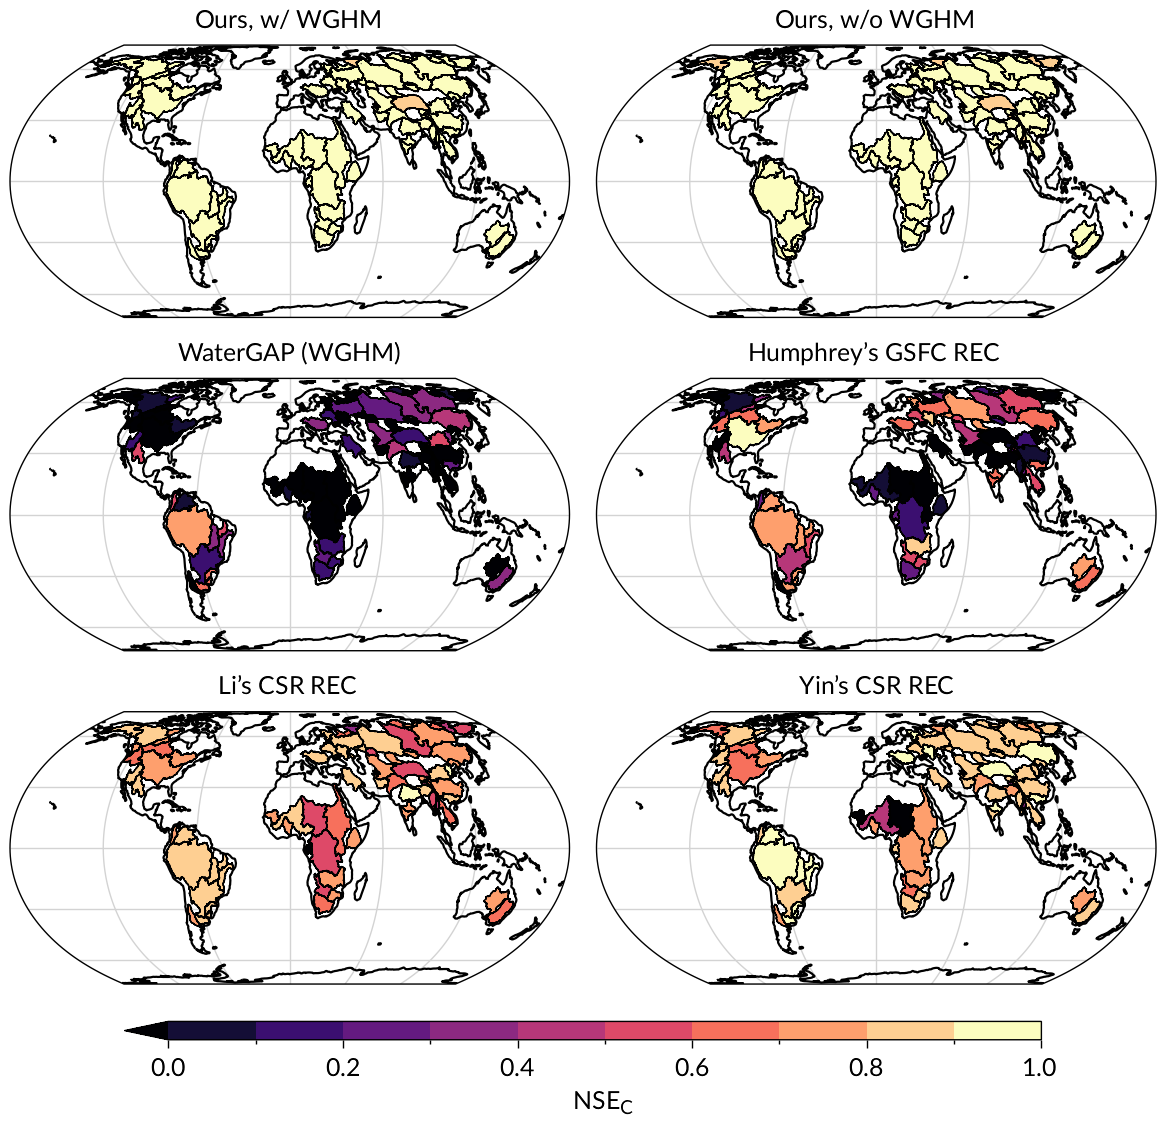

In [67]:
preds_basin_nsec = metrics.nsec(basin_avg[target_var], basin_avg[eval_vars])
da_basin_nsec = preds_basin_nsec.to_dataarray("model", name="nsec")

p = plot_basinwise_map(da_basin_nsec, da_nsec, col="model", levels=11, **plot_kwargs)

for ax, model in zip(p.axs.flat, da_nsec.model.values):
    ax.set_title(vars_verbose[model])
    basin_shapes.dw.projplot(ax=ax, **basinlines_kwargs)
p.fig.savefig(FIGURE_DIR / "metrics_nsec_basinwise.pdf", backend="pgf")

### Modified Kling–Gupta efficiency (KGE')

Modified Kling-Gupta Efficiency (KGE') as per [Kling et al., 2012](https://doi.org/10.1016/j.jhydrol.2012.01.011).

$$
    \text{KGE}^\prime = 1 -
    \sqrt{(r-1)^2 + (\beta-1)^2 + (\gamma-1)^2} \\
    r = \frac{\text{cov}(y, \hat y)}{\sigma \hat \sigma} \\
    \beta = \frac{\hat \mu}{\mu} \\
    \gamma = \frac{\hat \sigma / \hat \mu}{\sigma / \mu}
$$

In [68]:
plot_kwargs["vmin"] = -1
plot_kwargs["cmap"] = "cividis"

[########################################] | 100% Completed | 12.62 s
[########################################] | 100% Completed | 12.71 s


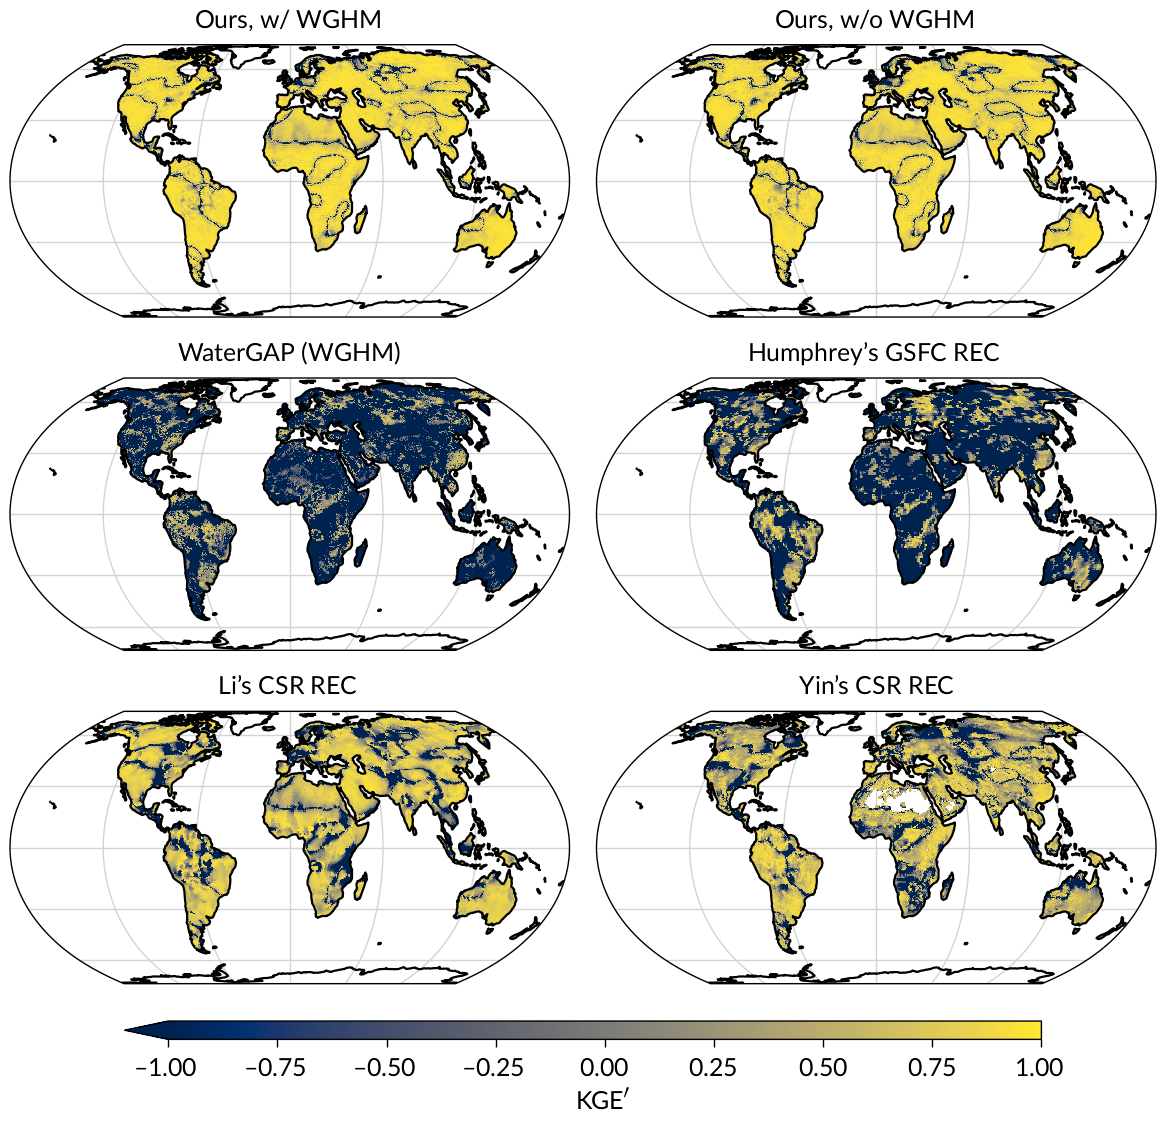

In [69]:
preds_kge = metrics.kgeprime(
    mgd_nona[target_var], mgd_nona[eval_vars], dim="time", skipna=True
)
da_kge = preds_kge.to_dataarray("model", name="kge").compute()

plot_kwargs["cbar_kwargs"]["label"] = r"KGE$^\prime$"


p = da_kge.dw.projplot(col="model", **plot_kwargs)

for ax, model in zip(p.axs.flat, da_kge.model.values):
    ax.set_title(vars_verbose[model])

p.fig.savefig(FIGURE_DIR / "metrics_kge_gridwise.pdf", backend="pgf")

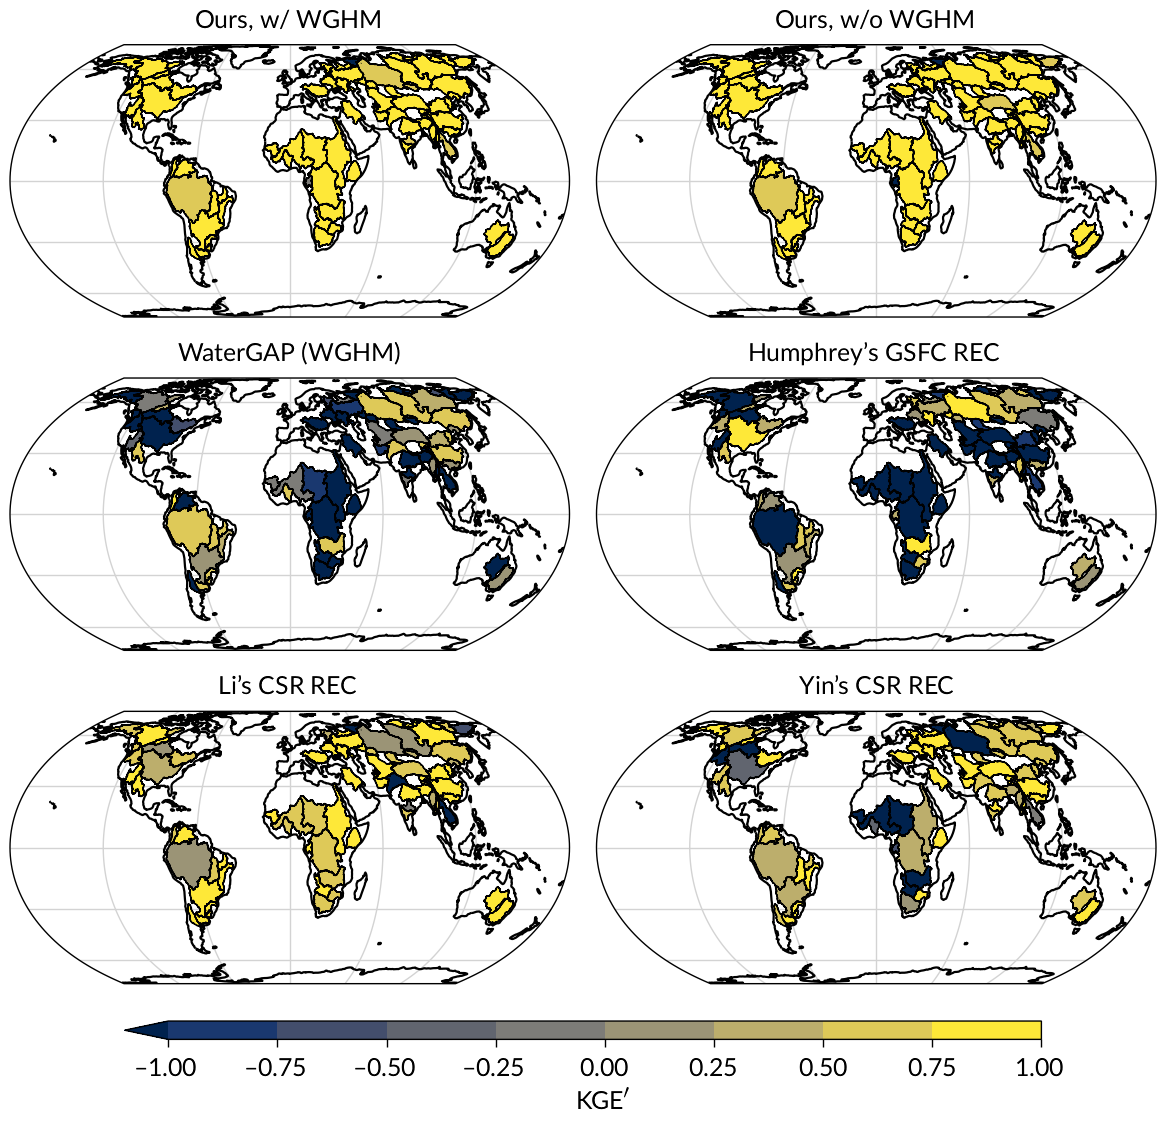

In [70]:
preds_basin_kge = metrics.kgeprime(
    basin_avg[target_var], basin_avg[eval_vars], dim="time"
)
da_basin_kge = preds_basin_kge.to_dataarray("model", name="kge")

p = plot_basinwise_map(da_basin_kge, da_kge, col="model", levels=9, **plot_kwargs)

for ax, model in zip(p.axs.flat, da_kge.model.values):
    ax.set_title(vars_verbose[model])
    basin_shapes.dw.projplot(ax=ax, **basinlines_kwargs)
p.fig.savefig(FIGURE_DIR / "metrics_kge_basinwise.pdf", backend="pgf")

## Averaged RMSE

Calculate the averaged grid-wise RMSE:

In [71]:
rmse_grid_avg = (
    da_rmse.dw.weight_lat().mean(["lat", "lon"]).rename("Grid-wise RMSE").compute()
)

Calculate the averaged basin-wise RMSE. We weigh each basin by the basin area:

In [72]:
basin_areas = basin_shapes.set_index(basin_shapes.river.rename("region")).shape_area
area_weights = xr.DataArray.from_series(basin_areas)

In [73]:
rmse_basin_avg = (
    da_basin_rmse.weighted(area_weights)
    .mean("region")
    .rename("Basin-wise RMSE")
    .compute()
)

In [74]:
table = (
    xr.merge([rmse_basin_avg, rmse_grid_avg])
    .to_pandas()
    .rename(vars_verbose)
    .sort_values(by="Basin-wise RMSE")
)
table

Basin-wise RMSE  Grid-wise RMSE
model                                               
Ours, w/ WGHM               5.533897       18.595713
Ours, w/o WGHM              6.690418       20.418724
Yin's CSR REC              14.612985       20.185809
Li's CSR REC               16.681413       29.327407
Humphrey's GSFC REC        25.901261       53.097857
WaterGAP (WGHM)            33.112374       84.598057

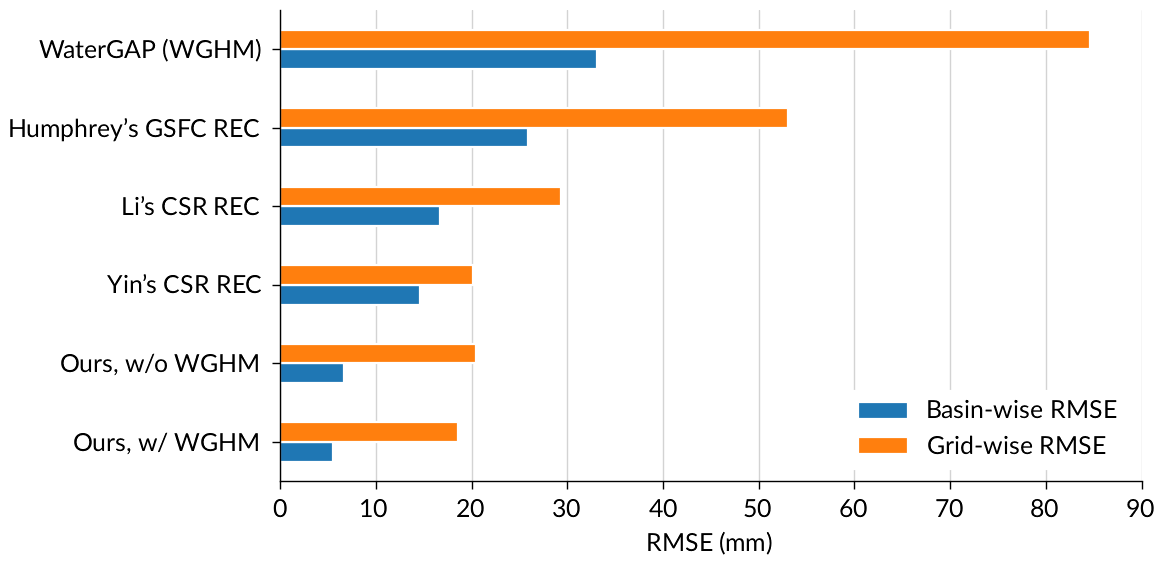

In [75]:
fig, ax = plt.subplots(figsize=(6, 3))
table.plot.barh(ax=ax)
ax.yaxis.grid(False)
ax.set(xlabel="RMSE (mm)", ylabel=None, xlim=(0, 90))
ax.legend(loc="lower right", frameon=True)
ax.xaxis.grid(True)
fig.savefig(FIGURE_DIR / "metrics_rmse_globalavg.pdf", backend="pgf")